# Data-driven nonlinear manifolds

## A general representation learning problem

In this notebook we demonstrate the construction of data-driven nonlinear manifolds for model reduction purposes. We learn the manifold through the identification of low-order, polynomial structure in the data through a general representation representation learning problem.<sup>[1](https://doi.org/10.48550/arXiv.2306.13748)</sup> In particular, we seek to build approximations of the form

$$
\mathbf{s}_j \approx \mathbf{s}_\text{ref} + \mathbf{V} \hat{\mathbf{s}}_j + \overline{\mathbf{V}} \boldsymbol{\Xi} \mathbf{g}(\hat{\mathbf{s}}_j), \quad \text{for } j=1,\dots,k,
$$

where $\mathbf{s}_j \in \mathbb{R}^{n}$ is the $j$th data sample, $\mathbf{s}_\text{ref} \in \mathbb{R}^{n}$ is a given reference state, $\mathbf{V} \in \mathbb{R}^{n \times r}$ and $\overline{\mathbf{V}} \in \mathbb{R}^{n \times q}$ are basis matrices, $\hat{\mathbf{s}}_j \in \mathbb{R}^{n \times r}$ is the reduced-state representation of the $j$th snapshot, and $\boldsymbol{\Xi} \in \mathbb{R}^{q \times (p-1)r}$ is the coefficient matrix. The total number of data samples is given by $k$. The vector $\mathbf{g}(\hat{\mathbf{s}}(t)) \in \mathbb{R}^{(p-1)r}$ has the form

$$
\mathbf{g}(\hat{\mathbf{s}}(t)) = \begin{pmatrix} \hat{\mathbf{s}}^2(t) \\
\hat{\mathbf{s}}^3(t) \\
\vdots                \\
\hat{\mathbf{s}}^p(t) 
\end{pmatrix},
% \label{eq:polynomial}
$$

where each $\hat{\mathbf{s}}^j(t) \in \mathbb{R}^r$ consists of the $j$th power of the components of $\hat{\mathbf{s}}(t)$, that is, $\hat{\mathbf{s}}^j(t) = [\hat{s}_1(t)^j,\hat{s}_2(t)^j,\dotsc,\hat{s}_r(t)^j]$.

## Problem setup & numerical implementation

First, we import the needed things from NumPy, Matplotlib and SciPy.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import jax.numpy as jnp
import jax

We generate the data by sampling the vector $\mathbf{s}(x,y)=\left(x,y,\sin(x)\cos(y)\right)^\top \in \mathbb{R}^3$ for $x,y \in [0,4]$. For centering the data we define the reference state $\mathbf{s}_\text{ref}$ as the column-averaged mean of the training data.

In [16]:
# create mesh grid
nx, ny = (41, 41)
num_snapshots = nx * ny
x = jnp.linspace(0, 4, nx)
y = jnp.linspace(0, 4, ny)
xx, yy = jnp.meshgrid(x, y)

# compute data matrix
fxy = jnp.sin(xx) * jnp.cos(yy)
S = jnp.reshape(jnp.array([xx, yy, fxy]), (3, num_snapshots))
sref = jnp.mean(S, axis=1)
Sref = jnp.array([sref,] * num_snapshots).T

Choose the model parameters:

In [17]:
p = 3           # degree of polynomial embeddings
r = 2           # number of basis vectors in Vr
q = 1           # number of basis vectors in Vbar
tol = 1e-4      # tolerence for alternating minimization
gamma = 0       # regularization parameter
max_iter = 100  # maximum number of iterations

We now create a number of useful function handles for quickly evaluating the function $\mathbf{g}(\hat{\mathbf{s}})$ and computing the relative state error:

In [18]:
def polynomial_form(x):
    """Polynomial representation of the reduced state snapshot data."""
    return jnp.array([x**degree for degree in range(2, p+1)])


def relative_error(S_exact, S_reconstructed):
    """Calculate the relative squared Frobenius-norm error."""
    return jnp.linalg.norm(S_exact - S_reconstructed, 'fro') / jnp.linalg.norm(S_exact - Sref, 'fro')

We also create a function for the visualizuation of the reconstructed data:

In [19]:
def plot_reconstruction(Gamma):
    """Plot the original data (fxy) and the reconstruction (fxy_Gamma)."""
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')

    fxy_Gamma = jnp.reshape(Gamma[2,::], (nx, ny))
    ax.plot_surface(xx, yy, fxy, color='gray', edgecolor='black', linewidth=0.1, alpha=0.2)
    surf = ax.plot_surface(xx, yy, fxy_Gamma, cmap='seismic', vmin=-1, vmax=1, alpha=0.8)

    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$f(x,y)$')
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 4)
    ax.set_zlim(-1, 1)
    ax.view_init(30, 130)
    fig.colorbar(surf, shrink=0.5, aspect=20, pad=0.1)

    plt.show()

## Comparison of representation learning methods

### 1. Traditional POD

We start with a simple POD method. We first compute the left singular vectors of the shifted data matrix. A two-dimensional representation of the data is then obtained by means of a projection onto the two-dimensional POD subspace. The corresponding approximation of the $j$th snapshot given by

$$
\mathbf{s}_j \approx \mathbf{s}_\text{ref} + \mathbf{V}\hat{\mathbf{s}}_j, \quad \text{for } j=1,\dots,k.
$$

In [20]:
U, ss, _ = jnp.linalg.svd(S - Sref, full_matrices=False)
Vr = U[:, :r]                   # select r leading singular vectors
Shat = Vr.T @ (S-Sref)          # represent data in POD coordinates

Gamma_POD = Sref + Vr @ Shat    # compute the projection of the original dataset
print(f"\nReconstruction error: {relative_error(S, Gamma_POD):.4%}")


Reconstruction error: 22.5640%


We can now plot the reconstructions obtained using POD:

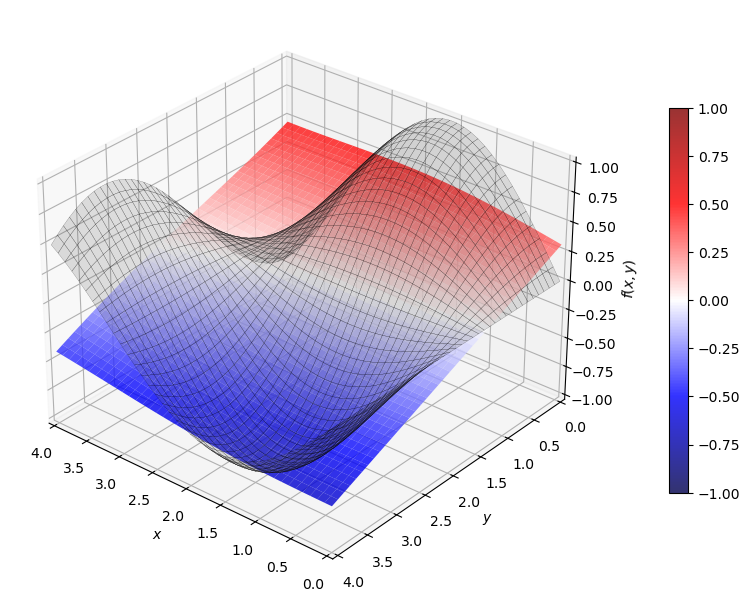

In [21]:
plot_reconstruction(Gamma_POD)

### 2. POD-based nonlinear manifold learning

In the POD-based manifold learning approach we choose the columns of $\mathbf{V}$ to be, as is the case in the traditional POD approach, the dominant two left singular vectors of the shifted data. The third singular vector now be contained in $\overline{\mathbf{V}}$. The coefficient matrix $\boldsymbol{\Xi} \in \mathbb{R}^{q \times (p-1)r}$  is computed via the normal equations.

In [22]:
Vbar = U[:, r:r+q]
Proj_error = S - Sref - (Vr @ Shat)
Poly = jnp.concatenate(polynomial_form(Shat), axis=0)
Xi = Vbar.T @ Proj_error @ Poly.T @ jnp.linalg.inv(Poly @ Poly.T + gamma * jnp.identity((p - 1)*r))

Gamma_MPOD = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
print(f"\nReconstruction error: {relative_error(S, Gamma_MPOD):.4%}")


Reconstruction error: 21.0644%


Plotting the reconstructed manifold using the nonlinear manifold based POD formulation:

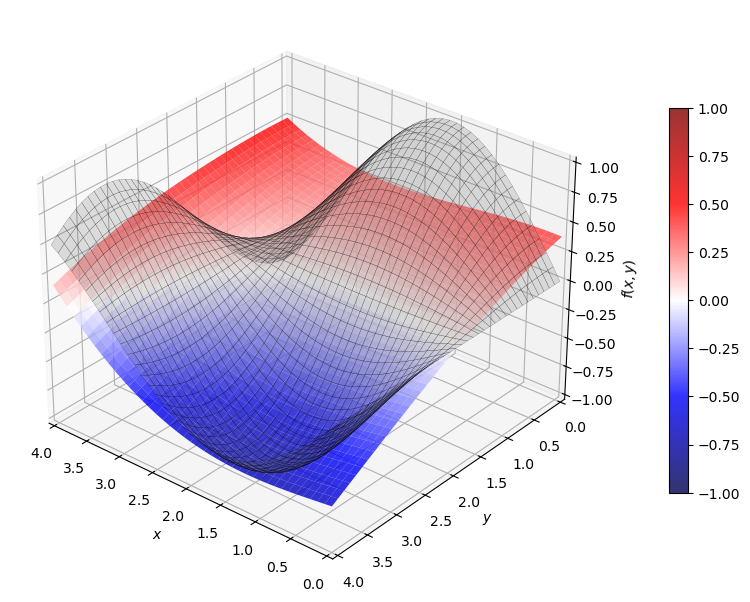

In [23]:
plot_reconstruction(Gamma_MPOD)

### 3. Alternating mimization based nonlinear manifold learning

The objective is successively minimized for the three blocks of variables in turn $-$ first $\boldsymbol{\Omega} = (\mathbf{V}, \overline{\mathbf{V}} )$, then $\boldsymbol{\Xi}$, then $\hat{\mathbf{S}}$ $-$ with the pattern repeating until a convergence criterion is satisfied. The minimization  with respect to $\boldsymbol{\Omega}$ is a standard problem known as the orthogonal Procrustes problem. The minimization with respect to $\boldsymbol{\Xi}$ is a linear least squares problem, as in above approach. The minimization with respect to $\hat{\mathbf{S}}$ decomposes into $k$ separate problems, each of which has a single reduced  state $\hat{\mathbf{s}}_j$ as its variable. 

In [25]:
from jaxopt import GaussNewton, LevenbergMarquardt
from jax import jit, vmap

def representation_learning_obj(x, snapshot_index):
    # x, snapshot_index = params
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ jnp.concatenate(polynomial_form(x), axis=0))


nrg_old = 0
print("***Starting alternating minimizations:")

def solve_snapshots_loop(i, carry):
    Shat = carry
    snapshot_index = jax.numpy.asarray(i, dtype=jax.numpy.int32)  # Assuming `i` is your loop index
    initial_guess = Shat[:, snapshot_index]

    gn = LevenbergMarquardt(residual_fun=representation_learning_obj, tol=1e-9)
    result = gn.run(init_params=initial_guess, snapshot_index=snapshot_index)

    # Update only the relevant part of Shat based on optimization result
    updated_Shat = Shat.at[:, snapshot_index].set(result.params)  # Assuming result contains optimized params

    return updated_Shat  # This ensures the structure of carry remains consistent


# @jit
def nonlinear_regression_step(snapshot_index, Shat):
    """Nonlinear regression step for a single snapshot."""
    LM = LevenbergMarquardt(residual_fun=representation_learning_obj, tol=1e-9)
    initial_guess = Shat[:, snapshot_index]
    return LM.run(init_params=initial_guess, snapshot_index=snapshot_index).params
 


# start iterations
for niter in range(max_iter):

    # step 1 - orthogonal Procrustes (update basis vectors)
    Um, _ , Vm = jnp.linalg.svd((S - Sref) @ jnp.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
    Omega = Um @ Vm
    Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

    # step 2 - linear regression (update coefficient matrix)
    Proj_error = S - Sref - (Vr @ Shat)
    rhs = jnp.linalg.inv(Poly @ Poly.T + (gamma * jnp.identity((p - 1)*r)))
    Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

    # step 3 - nonlinear regression (update reduced state representation)
    # Shat = jax.lax.fori_loop(lower=0, upper=num_snapshots, body_fun=solve_snapshots_loop, init_val=Shat)
    LM = LevenbergMarquardt(residual_fun=representation_learning_obj, tol=1e-9)
            # Step 3 - Nonlinear regression (update reduced state representation)
    Shat = vmap(nonlinear_regression_step, in_axes=[0, None])(jnp.arange(num_snapshots), Shat).T
    # Shat = jnp.array(Shat)
    # for snapshot in range(num_snapshots):
    #     Shat[:, snapshot] = opt.least_squares(lambda x: representation_learning_obj(x, snapshot), Shat[:, snapshot], ftol=1e-9, ).x
    #     # Shat = Shat.at[:, snapshot].set(opt.least_squares(representation_learning_obj, Shat[:, snapshot], ftol=1e-9).x)
    Poly = jnp.concatenate(polynomial_form(Shat), axis=0)

    # evaluate convergence criterion
    energy = jnp.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / jnp.linalg.norm(S - Sref, 'fro')**2
    diff = abs(energy - nrg_old)
    print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
    if diff < tol:
        print("***Convergence criterion active!")
        break
    nrg_old = energy # update old energy metric


Gamma_MAM = Sref + (Vr @ Shat) + (Vbar @ Xi @ Poly)
print(f"\nReconstruction error: {relative_error(S, Gamma_MAM):.4%}")

***Starting alternating minimizations:
	iteration: 1	snapshot energy: 9.856023e-01	 diff: 9.856023e-01
	iteration: 2	snapshot energy: 9.861798e-01	 diff: 5.774498e-04
	iteration: 3	snapshot energy: 9.874676e-01	 diff: 1.287818e-03


KeyboardInterrupt: 

Plotting the reconstructed manifold using the alternating mimization formulation:

In [11]:
import jax.numpy as np
from jax import jit, vmap
from jax.scipy.linalg import svd
from jaxopt import GaussNewton, LevenbergMarquardt


def polynomial_form(x, p):
    """Polynomial representation of the reduced state snapshot data."""
    return [x**degree for degree in range(2, p+1)]


@jit
def relative_error(S_exact, S_reconstructed, Sref):
    """Calculate the relative squared Frobenius-norm error."""
    return np.linalg.norm(S_exact - S_reconstructed, 'fro') / np.linalg.norm(S_exact - Sref, 'fro')


@jit
def representation_learning_obj(x, snapshot_index, Vr, Vbar, Xi, S, sref, p=2):
    """Objective function for the nonlinear regression problem in the alternating minimization approach."""
    return S[:, snapshot_index] - sref - (Vr @ x) - (Vbar @ Xi @ np.concatenate(polynomial_form(x, p), axis=0))


@jit
def alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p, initial_Shat=None):
    """
    Performs alternating minimization to solve for Shat given the system parameters.
    
    :param S: The system snapshots.
    :param Sref: The reference state.
    :param num_snapshots: Number of snapshots in S.
    :param max_iter: Maximum number of iterations for the minimization process.
    :param tol: Tolerance for convergence criterion.
    :param initial_Shat: Initial guess for Shat.
    :param gamma: Regularization parameter.
    :param r: Rank for Vr.
    :param q: Rank for Vbar.
    :param p: Order of polynomial form.
    :return: Optimized Shat and the final energy.
    """

    sref = Sref[:, 0]
    nrg_old = 0
    print("***Starting alternating minimizations:")

    U, _, _ = jax.scipy.linalg.svd(S - Sref, full_matrices=False)
    Vr = U[:, :r]
    # Vr = jax.lax.slice(U, (0, 0), (len(U), r))
    Vbar = U[:, r:r+q]
    # Vbar = jax.lax.slice(U, (0, r), (len(U), r + q))
    
    # Initialize Shat and other variables
    if initial_Shat is None:
        Shat = Vr.T @ (S - Sref)  # represent data in POD coordinates
    else:
        Shat = initial_Shat
    
    Proj_error = S - Sref - (Vr @ Shat)
    Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)
    Xi = Vbar.T @ Proj_error @ Poly.T @ np.linalg.inv(Poly @ Poly.T + gamma * np.eye((p - 1) * r))
    
    @jit
    def iteration_step(Shat, Vr, Vbar, Xi, Poly):
        # Step 1 - Orthogonal Procrustes (update basis vectors)
        Um, _, Vm = svd((S - Sref) @ np.concatenate([Shat, Xi @ Poly]).T, full_matrices=False)
        Omega = Um @ Vm
        Vr, Vbar = Omega[:, :r], Omega[:, r:r+q]

        # Step 2 - Linear regression (update coefficient matrix)
        Proj_error = S - Sref - (Vr @ Shat)
        rhs = np.linalg.inv(Poly @ Poly.T + (gamma * np.eye((p - 1) * r)))
        Xi = Vbar.T @ Proj_error @ Poly.T @ rhs

        # Step 3 - Nonlinear regression (update reduced state representation)
        Shat = vmap(lambda x: LevenbergMarquardt(lambda y: representation_learning_obj(y, x, Vr, Vbar, Xi, S, sref, p=p), Shat[:, x], ftol=1e-9).x)(np.arange(num_snapshots)).T
        Poly = np.concatenate(polynomial_form(Shat, p=p), axis=0)

        return Shat, Vr, Vbar, Xi, Poly

    for niter in range(max_iter):
        Shat, Vr, Vbar, Xi, Poly = iteration_step(Shat, Vr, Vbar, Xi, Poly)

        # Evaluate convergence criterion
        energy = np.linalg.norm(Vr @ Shat + (Vbar @ Xi @ Poly), 'fro')**2 / np.linalg.norm(S - Sref, 'fro')**2
        diff = abs(energy - nrg_old)
        print(f"\titeration: {niter+1:d}\tsnapshot energy: {energy:e}\t diff: {diff:e}")
        if diff < tol:
            print("***Convergence criterion active!")
            break
        nrg_old = energy  # Update old energy metric

    return Shat, energy, Xi, Vr, Vbar, Poly

# To call this function, you would need to prepare all the required arguments first.
# For example:
S = jnp.array(S)
Sref = jnp.array(Sref)
Shat_optimized, final_energy = alternating_minimization(S, Sref, num_snapshots, max_iter, tol, gamma, r, q, p)

***Starting alternating minimizations:


IndexError: Array slice indices must have static start/stop/step to be used with NumPy indexing syntax. Found slice(None, Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>, None). To index a statically sized array at a dynamic position, try lax.dynamic_slice/dynamic_update_slice (JAX does not support dynamically sized arrays within JIT compiled functions).

In [ ]:
plot_reconstruction(Gamma_MAM)

## Useful references

  1. Geelen, R., Balzano, L. and Willcox, K., 2023. Learning latent representations in high-dimensional state spaces using polynomial manifold constructions. arXiv preprint arXiv:2306.13748. [doi.org/10.48550/arXiv.2306.13748](https://doi.org/10.48550/arXiv.2306.13748)
  2. Geelen, R., Balzano, L., Wright, S. and Willcox, K., 2023. Learning physics-based reduced-order models from data using nonlinear manifolds.
  3. Geelen, R., Wright, S. and Willcox, K., 2023. Operator inference for non-intrusive model reduction with quadratic manifolds. Computer Methods in Applied Mechanics and Engineering, 403, p.115717. [doi.org/10.1016/j.cma.2022.115717](https://doi.org/10.1016/j.cma.2022.115717)